In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
ls

gdrive/  sample_data/


In [ ]:
%cd gdrive

/content/gdrive


In [ ]:
ls

MyDrive/


In [ ]:
%cd MyDrive

/content/gdrive/MyDrive


In [ ]:
%cd PV01

/content/gdrive/MyDrive/PV01


In [ ]:
pwd

'/content'

In [ ]:
ls

mask/  non_mask/


In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './non_mask/')
mask_path = os.path.join(path, './mask/')

In [ ]:

image_list_orig = os.listdir(image_path)
mask_list_orig=[]
for i in range(len(image_list_orig)):
  mask_list_orig.append(image_list_orig[i][:-4]+'_label.bmp')
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in mask_list_orig]

<ipython-input-13-257938548a2f>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-13-257938548a2f>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

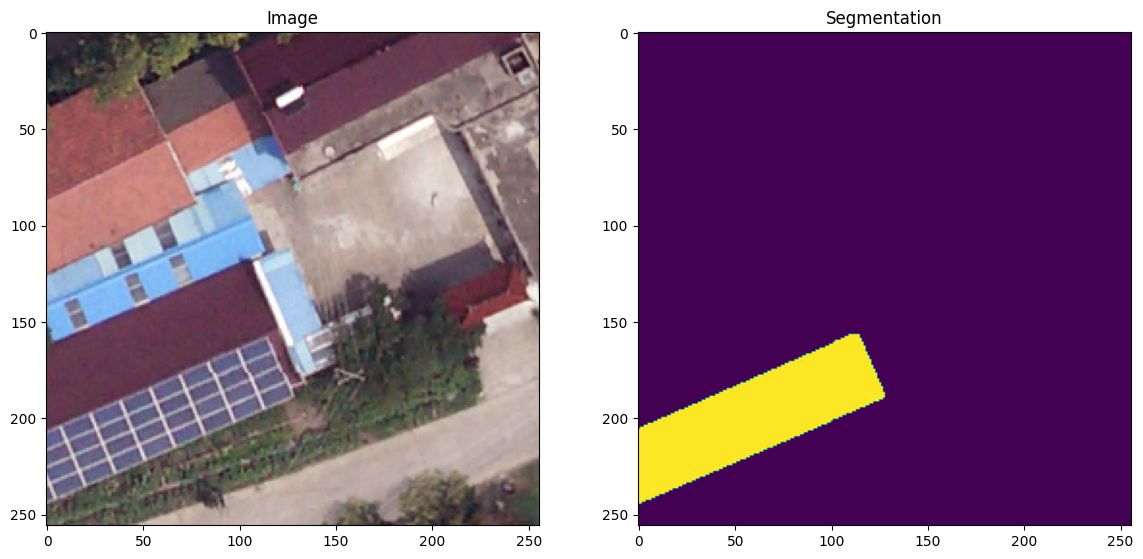

In [ ]:
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./non_mask/PV01_324942_1203839.bmp'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./mask/PV01_324942_1203839_label.bmp'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./non_mask/PV01_324942_1203842.bmp'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./mask/PV01_324942_1203842_label.bmp'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./non_mask/PV01_324951_1203793.bmp'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./mask/PV01_324951_1203793_label.bmp'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./non_mask/PV01_324942_1203839.bmp', shape=(), dtype=string)
tf.Tensor(b'./mask/PV01_324942_1203839_label.bmp', shape=(), dtype=string)


In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_bmp(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_bmp(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='sigmoid',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='sigmoid',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(2,strides=2)(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
# UNQ_C2
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='sigmoid',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='sigmoid',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [ ]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=2):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='sigmoid',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(256, 256, 1)


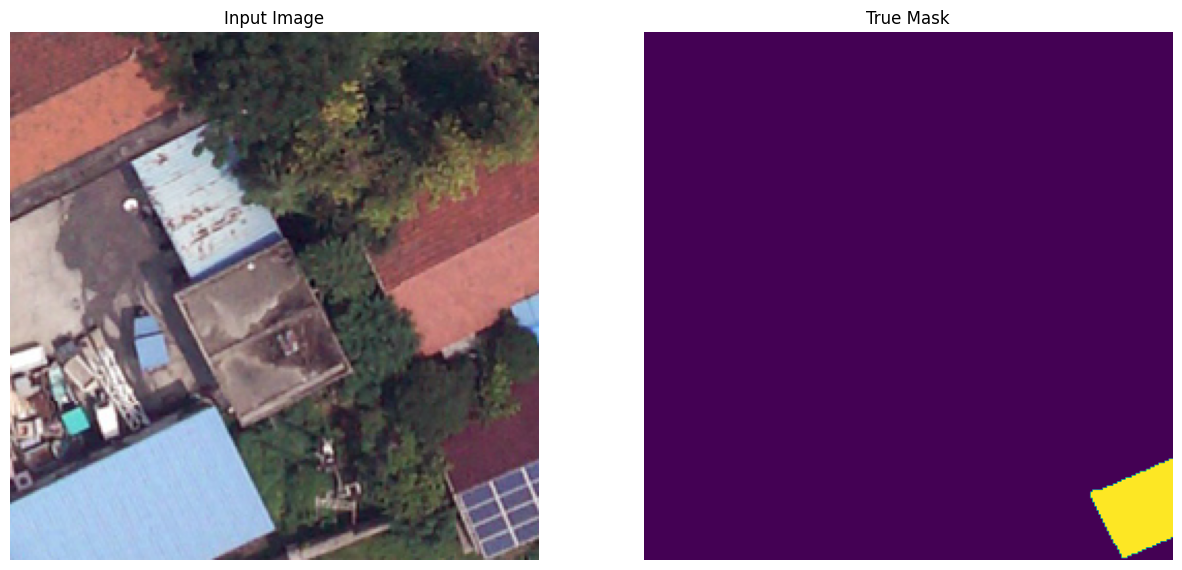

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [ ]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_20[0][0]']              
                                )                                                           

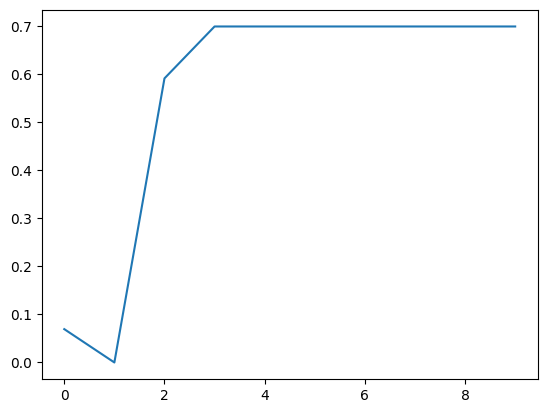

In [ ]:
plt.plot(model_history.history["accuracy"])

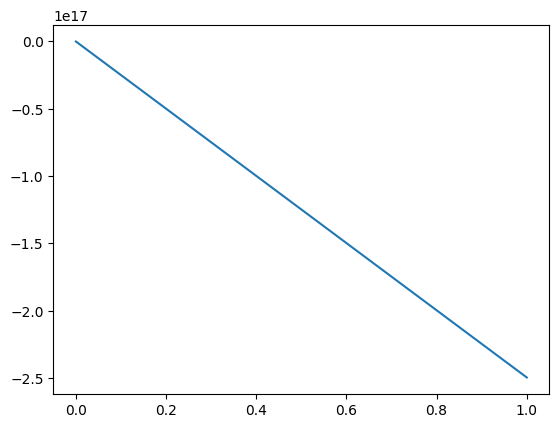

In [ ]:
plt.plot(model_history.history["loss"])

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss=total_loss, metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = model.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/10
21/21 [==============================] - 691s 33s/step - loss: -52494594048.0000 - acc: 0.0563
Epoch 2/10
21/21 [==============================] - 641s 30s/step - loss: -1116651021188202496.0000 - acc: 0.0000e+00
Epoch 3/10
21/21 [==============================] - 637s 30s/step - loss: nan - acc: 0.6304
Epoch 4/10
21/21 [==============================] - 628s 30s/step - loss: nan - acc: 0.7000
Epoch 5/10
21/21 [==============================] - 637s 30s/step - loss: nan - acc: 0.7000
Epoch 6/10
21/21 [==============================] - 636s 30s/step - loss: nan - acc: 0.7000
Epoch 7/10
21/21 [==============================] - 640s 30s/step - loss: nan - acc: 0.7000
Epoch 8/10
21/21 [==============================] - 635s 30s/step - loss: nan - acc: 0.7000
Epoch 9/10
21/21 [==============================] - 638s 30s/step - loss: nan - acc: 0.7000
Epoch 10/